# Training

I have successfully been able to build a sort of data set for this model. Now I want to try training on my data.

In [20]:
import sys
!{sys.executable} -m pip install cupy-cuda11x
!{sys.executable} -m pip install torch torchvision torchaudio

You should consider upgrading via the 'c:\Python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Python38\python.exe -m pip install --upgrade pip' command.


In [7]:
import pandas as pd
import numpy as np

# first we need to read the data in

data_name = 'dataset.csv'

all_data = pd.read_csv(data_name)
all_data

,netIncomePerShare,freeCashFlowPerShare,peRatio,priceToSalesRatio,pbRatio,debtToEquity,dividendYield,payoutRatio,roe,ticker,label
0,0.037304,0.081930,68.692936,16.198334,3.792215,1.051065,0.000404,0.111111,0.013801,CMCSA,0.0
1,0.366850,0.337912,8.135137,18.134324,3.515821,0.918390,0.000015,0.000485,0.108044,CMCSA,1.0
2,0.132520,0.173255,18.516105,6.586352,1.420348,0.761143,0.003187,0.236057,0.019177,CMCSA,0.0
3,0.071330,0.172091,29.580969,5.532793,1.205178,0.746057,0.003692,0.436893,0.010185,CMCSA,0.0
4,0.133795,0.211265,12.743329,4.438462,0.957572,0.715781,0.004574,0.233161,0.018786,CMCSA,0.0
...,...,...,...,...,...,...,...,...,...,...,...
136443,0.600000,1.265324,3.083333,3.700391,0.383926,0.001104,0.000011,0.000135,0.031129,SNGR.L,0.0
136444,0.400000,0.948329,4.281250,3.332726,0.322385,0.001067,0.256648,4.395096,0.018825,SNGR.L,0.0
136445,0.792549,1.878183,2.160751,2.286619,0.339581,0.001007,0.000037,0.000320,0.039290,SNGR.L,1.0
136446,1.200000,1.440450,1.614583,2.256612,0.362996,0.000928,0.000067,0.000433,0.056206,SNGR.L,1.0


In [75]:
# let's try a new strategy for normalization
# we'll update each value to be the z-score of the value within the overall distribution
def zscore_data(data, cols_to_normalize=None, feature_size=9):
    cols_for_normalizing = data.columns[:feature_size]

    if cols_to_normalize:
        cols_for_normalizing = cols_to_normalize
    
    for col in cols_for_normalizing:
        col_data = data[col]
        mu = np.mean(col_data)
        sigma = np.std(col_data)

        data[col] = (data[col] - mu) / sigma

    return data

def normalize_data(data, cols_to_normalize=None, feature_size=9):
    cols_for_norm = data.columns[:feature_size]

    if cols_to_normalize:
        cols_for_norm = cols_to_normalize
    
    for col in cols_for_norm:
        col_data = data[col]
        min_val = np.min(col_data)
        max_val = np.max(col_data)

        data[col] = (data[col] - min_val) / (max_val - min_val)
    
    return data

all_data = normalize_data(zscore_data(all_data))

In [8]:
# We may need to consolidate larger values by taking the log of our data before
# trying to pull out outliers

def log_data(data, cols_to_log=None, feature_size=9):
    cols_for_logging = data.columns[:feature_size]

    if cols_to_log:
        cols_for_logging = cols_to_log

    for col in cols_for_logging:
        # we have to offset all data by the absolute value of it if its negative
        info = data[col].describe()
        if info['min'] < 0:
            data[col] = data[col] + np.abs(info['min']) + 1

        data[col] = np.log(data[col])
    
    return data

all_data = log_data(all_data)
all_data

,netIncomePerShare,freeCashFlowPerShare,peRatio,priceToSalesRatio,pbRatio,debtToEquity,dividendYield,payoutRatio,roe,ticker,label
0,9.789873,14.7112,18.518706,11.567448,8.644031,11.667213,-7.813165,9.288283,5.373945,CMCSA,0.0
1,9.789891,14.7112,18.518705,11.567466,8.643982,11.667212,-11.112948,9.288273,5.374382,CMCSA,1.0
2,9.789878,14.7112,18.518705,11.567357,8.643613,11.667211,-5.748617,9.288295,5.373970,CMCSA,0.0
3,9.789875,14.7112,18.518705,11.567347,8.643575,11.667211,-5.601492,9.288314,5.373929,CMCSA,0.0
4,9.789878,14.7112,18.518705,11.567337,8.643531,11.667210,-5.387330,9.288295,5.373969,CMCSA,0.0
...,...,...,...,...,...,...,...,...,...,...,...
136443,9.789904,14.7112,18.518705,11.567330,8.643430,11.667204,-11.419512,9.288273,5.374026,SNGR.L,0.0
136444,9.789893,14.7112,18.518705,11.567326,8.643419,11.667204,-1.360050,9.288680,5.373969,SNGR.L,0.0
136445,9.789915,14.7112,18.518705,11.567316,8.643422,11.667204,-10.202989,9.288273,5.374064,SNGR.L,1.0
136446,9.789938,14.7112,18.518705,11.567316,8.643426,11.667204,-9.609178,9.288273,5.374142,SNGR.L,1.0


In [9]:
# We need to attempt to handle outliers in our data.
# this removes outliers based on the interquartile range
def remove_outliers_iqr(data, iqr_mod=1.5, feature_size=9):
    cols_for_trimming = data.columns[:feature_size]

    # we need to go through each feature and check the inter quartile ranges.
    # we'll drop values with info outside of the multiplier on the range we
    # provided
    print('Old length: {:d}'.format(len(data)))
    for col in cols_for_trimming:
        info = data[col].describe()
        range_add = (info['75%'] - info['25%']) * iqr_mod
        data = data[(data[col] >= info['25%'] - range_add)]
        data = data[(data[col] <= info['75%'] + range_add)]
    print('New length: {:d}'.format(len(data)))

    return data


# it might be useful to try making one for the z-score, but I don't know
# if our distribution is normalized.

all_data = remove_outliers_iqr(all_data, 5)

Old length: 136448
New length: 108152


In [10]:
# there are a couple of preliminary steps we need to take. 

# 1) handle outliers
# 2) normalize all of the data (0 to 1)
# 3) separate testing and training sets


def normalize_data(data, feature_size=9):
    cols_for_normalization = data.columns[:feature_size]
    
    for col in cols_for_normalization:
        max = data[col].max()
        min = data[col].min()
        print(max)

        data[col] = (data[col] - min) / (max - min)

normalize_data(all_data)

9.790051250741316
14.711201294824106
18.518706486141376
11.568015320151485
8.645939524629462
11.667243503526587
3.6137942376991385
9.288617587790053
5.374716997680058


In [11]:
# separate training and test sets

def separate_sets(data, prop_test, prop_train=0, feature_size=9):

    # we need to drop superfluous info like tickers
    data = data.drop(['ticker'], axis=1)

    if prop_train == 0 or prop_train + prop_test > 1:
        prop_train = 1 - prop_test
    
    # we find out the ratio to take from the remaining portion
    prop_train = (1 - prop_test) / prop_train
    if prop_train > 1:
        prop_train = 1

    test_set = data.sample(frac=prop_test)
    data = data.drop(test_set.index)
    train_set = data.sample(frac=prop_train)

    test_f = np.array(test_set[test_set.columns[:feature_size]])
    test_l = np.concatenate(np.array(test_set[test_set.columns[feature_size:]]))

    train_f = np.array(train_set[train_set.columns[:feature_size]])
    train_l = np.concatenate(np.array(train_set[train_set.columns[feature_size:]]))

    return (test_f, test_l, train_f, train_l)

test_features, test_labels, train_features, train_labels = separate_sets(all_data, .2)

train_labels

array([0., 0., 0., ..., 0., 0., 1.])

# Building the Model

Now that we have theoretcially written everything needed to properly prep the data, we need to choose a model to implement. I think for now I will attempt to start off with basic logistic regression and increase complexity as needed.

This means we will need a: 
* predictor
* loss function
* derivative of loss function
* gradient descent function

In [12]:
def make_prediction(weights, features):
    return 1 / (1 + np.exp(-np.dot(weights[1:], features) - weights[0]))

make_prediction([-.5] * 10, train_features[0])

0.050714426032425215

# The Loss Functions

I didn't actually remember the math behind this so I looked up a good logistic regression algorithm loss and gradient of the loss function. That way I can guarantee, or at least better guarantee, that if something is wrong it's not this.

In [13]:
# I think a simple 1 or 0 single loss function might be the best for now
# we can come back and change it later if need be

# I got this from a youtube video. Math is hard. 
def single_loss_log(weights, features, label):
    y_hat = make_prediction(weights, features)
    return label * np.log(y_hat) + (1 - label) * np.log(1 - y_hat)

def batch_loss(batch_start_ind, batch_size, loss_func, weights, train_f, train_l):
    total_loss = 0
    for point_ind in range(batch_size):
        total_loss += loss_func(weights, train_f[(point_ind + batch_start_ind) % len(train_f)], train_l[(point_ind + batch_start_ind) % len(train_l)])
    return total_loss / batch_size

single_loss_log([-.5] * 10, train_features[0], train_labels[0])
batch_loss(0, len(train_labels), single_loss_log, [-.5] * 10, train_features, train_labels)

-1.405312891220998

In [14]:
def batch_gradient(batch_start_ind, batch_size, weights, train_f, train_l):
    total_diff_theta = np.array([0.0] * (len(weights) - 1))
    total_diff_b = 0
    for point_ind in range(batch_size):
        y_diff = make_prediction(weights, train_f[(point_ind + batch_start_ind) % len(train_f)]) - train_l[(point_ind + batch_start_ind) % len(train_l)]
        total_diff_theta +=  y_diff * train_f[(point_ind + batch_start_ind) % len(train_f)]
        total_diff_b += y_diff
    total_diff_theta = np.insert(total_diff_theta, 0, total_diff_b)

    total_diff_theta /= batch_size

    return total_diff_theta

grad = batch_gradient(0, len(train_labels), [-.5] * 10, train_features, train_labels)
grad

array([-0.42299347, -0.21851647, -0.21540112, -0.21264499, -0.21566311,
       -0.21964421, -0.21597139, -0.20694553, -0.2154822 , -0.21748527])

In [15]:
def batch_descent(train_l, train_f, batch_size, step_size, threshold, weights=np.array([0] * 10)):
    batch_ind = 0
    grad_mag = threshold + 100

    while grad_mag > threshold:
        try:
            grad = batch_gradient(batch_ind, batch_size, weights, train_f, train_l)

            grad_mag = np.linalg.norm(grad)

            # let's descend!
            weights = weights - step_size * grad

            batch_ind += batch_size
            print('Num batches: {:d}. Gradient magnitude: {:.8f}'.format(batch_ind // batch_size, grad_mag), end='\r', flush=True)
        except:
            break
    
    print(weights)
    return weights

trained_model = batch_descent(train_labels, train_features, len(train_labels), 2, .00002723)

[-0.05709536  0.02881672  0.01583017 -0.02107941 -0.0150407   0.04700797
 -0.02403506 -0.05216017 -0.05735908  0.06526121]


In [17]:
def calc_error(test_f, test_l, weights, conf):
    total = 0
    test_total = 0
    for point_ind in range(len(test_l)):
        expectation = make_prediction(weights, test_f[point_ind])
        
        test_total += test_l[point_ind]

        if (expectation - .5) * ( test_l[point_ind] - .5) < 0:
            total += 1
    
    return total / len(test_l)

calc_error(test_features, test_labels, trained_model, 0)

0.4782709200184928

In [18]:
# this is a method which caclulates error based on the ability to abstain for values below a given confidence interval
def calc_abs_error(test_f, test_l, weights, interval):
    total = 0
    test_total = 0
    for point_ind in range(len(test_l)):
        expectation = make_prediction(weights, test_f[point_ind])
        
        test_total += test_l[point_ind]

        if (expectation - .5) * ( test_l[point_ind] - .5) < 0:
            # false positive with confidence below interval
            if (expectation > .5):
                if(expectation > interval):
                    total+= 1
            else:
                total += 1
    
    return total / len(test_l)

In [27]:
# I want to be able to make a graph of the error over epochs
# so I am going to do that here
def batch_descent_error_tracking(train_l, train_f, test_f, test_l, batch_size, step_size, threshold, error_calculator, weights=np.array([0] * 10), conf_cutoff=.8):
    batch_ind = 0
    grad_mag = threshold + 100
    test_errors = list()
    train_errors = list()

    while grad_mag > threshold:
        try:
            grad = batch_gradient(batch_ind, batch_size, weights, train_f, train_l)

            grad_mag = np.linalg.norm(grad)

            # let's descend!
            weights = weights - step_size * grad
            test_errors.append(error_calculator(test_f, test_l, weights, conf_cutoff))
            train_errors.append(error_calculator(train_f, train_l, weights, conf_cutoff))

            batch_ind += batch_size
            print('Num batches: {:d}. Gradient magnitude: {:.8f}'.format(batch_ind // batch_size, grad_mag), end='\r', flush=True)
        except:
            break
    
    print(weights)
    return weights, test_errors, train_errors

confidence_cutoff = .6
trained_model, test_errors, train_errors = batch_descent_error_tracking(train_labels, train_features, test_features, test_labels, len(train_labels), 2, .0005, calc_abs_error, conf_cutoff=confidence_cutoff)
test_errors

[-0.88891981  0.4651364   0.24729517 -0.04405216 -0.09707551  0.97741274
 -0.03164045 -0.32803687 -0.43440791  0.85549133]


[0.47831715210355985,
 0.47831715210355985,
 0.47831715210355985,
 0.47831715210355985,
 0.47831715210355985,
 0.47831715210355985,
 0.47831715210355985,
 0.47831715210355985,
 0.47831715210355985,
 0.47831715210355985,
 0.47831715210355985,
 0.4781784558483588,
 0.4778548312528895,
 0.4778085991678225,
 0.4770688858067499,
 0.4763291724456773,
 0.4753120665742025,
 0.4738326398520573,
 0.4727230698104484,
 0.47128987517337034,
 0.4698566805362922,
 0.46851595006934815,
 0.46638927415626447,
 0.46449375866851594,
 0.46199722607489596,
 0.46042533518261675,
 0.4579750346740638,
 0.455663430420712,
 0.4534442903374942,
 0.451918631530282,
 0.4497457235321313,
 0.4472029588534443,
 0.4453074433656958,
 0.44359685621821543,
 0.4416088765603329,
 0.43929727230698107,
 0.4369856680536292,
 0.43546000924641703,
 0.4335644937586685,
 0.43148404993065187,
 0.4293573740175682,
 0.42736939435968563,
 0.4257050392972723,
 0.4239019879796579,
 0.42219140083217754,
 0.420249653259362,
 0.41853906611

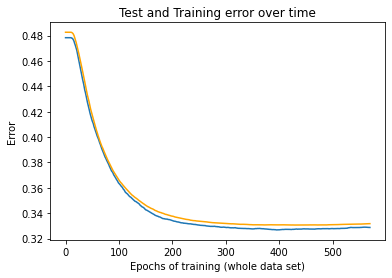

In [28]:
# we need to make a graph of this

import matplotlib.pyplot as plt

plt.plot(range(len(test_errors)), test_errors)
plt.plot(range(len(train_errors)), train_errors, color='orange')
plt.xlabel('Epochs of training (whole data set)')
plt.ylabel('Error')
plt.title('Test and Training error over time')
plt.savefig('model1perf.jpg')
plt.show()



In [29]:
# I need to know how many predictions we make that we end up betting on
total_buys = 0
for point_ind in range(len(test_labels)):
    expect = make_prediction(trained_model, test_features[point_ind])

    if expect > confidence_cutoff:
        total_buys += 1

print(total_buys)
print('{:2.2f}% of stocks bought'.format(total_buys / len(test_labels) * 100))

435
2.01% of stocks bought


# ANN Analysis

I am going to build a 9-10-10-1 fully connected network with a basic sigmoid activation function.

In [243]:
# lets make our pytorch imports
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import itertools

In [237]:
# let's build our model 5 layers

class NeuralNetwork(nn.Module):
    def __init__(self, input, h1, h2, h3, out):
        super(NeuralNetwork, self).__init__()
        
        self.layer_1 = nn.Linear(input, h1)
        nn.init.uniform_(self.layer_1.weight)
        self.layer_2 = nn.Linear(h1, h2)
        nn.init.uniform_(self.layer_2.weight)
        self.layer_3 = nn.Linear(h2, h3)
        nn.init.uniform_(self.layer_3.weight)
        self.layer_4 = nn.Linear(h3, out)
        nn.init.uniform_(self.layer_4.weight)
    
    def forward(self, x):
        y = torch.sigmoid(self.layer_1(x))
        y = torch.sigmoid(self.layer_2(y))
        y = torch.sigmoid(self.layer_3(y))
        y = torch.sigmoid(self.layer_4(y))
        return y
        

model = NeuralNetwork(9, 10, 8, 5, 1)
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=9, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=5, bias=True)
  (layer_4): Linear(in_features=5, out_features=1, bias=True)
)


In [244]:
# let's build our model 5 layers

class NeuralNetwork(nn.Module):
    def __init__(self, input, h1, out):
        super(NeuralNetwork, self).__init__()
        
        self.layer_1 = nn.Linear(input, h1)
        nn.init.uniform_(self.layer_1.weight)
        self.layer_2 = nn.Linear(h1, out)
    def forward(self, x):
        y = torch.sigmoid(self.layer_1(x))
        y = torch.sigmoid(self.layer_2(y))
        return y
        

model = NeuralNetwork(9, 10, 1)
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=9, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


In [245]:
# let's set our parameters like loss and learning rate
learn_rate = 100
batch_size = 32
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

In [246]:
# now we need to make a special data object to pass
# our data into our network

class Data(Dataset):
    def __init__(self, x, y):
        self.X = torch.from_numpy(x.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.len

train_data = Data(train_features, train_labels)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)

test_data = Data(test_features, test_labels)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)


In [247]:
# let's calculate the number of misclassifications in a set
def calc_frac_wrong(cur_model, dataloader):
    wrong = 0
    total = 0
    

    for X, y in dataloader:
        pred = cur_model(X)
        predicted = np.where(pred < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        wrong += (predicted != y.numpy()).sum().item()
        total += y.size(0)
    
    return wrong / total

In [248]:
# for X, y in train_dataloader:
#     print(model(X))

In [249]:
# let's train!

num_epochs = 10
losses = list()
test_loss = list()

for epoch in range(num_epochs):

    curLoss = 0
    for X, y in train_dataloader:
        optimizer.zero_grad()

        pred = model(X)
        # print(pred)
        loss = loss_fn(pred, y.unsqueeze(-1))
        curLoss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(curLoss / len(train_dataloader))
    
    test_loss.append(calc_frac_wrong(model, test_dataloader))

    print('Epoch {:d} training error: {:.20f}'.format(epoch, losses[-1]), end='\r', flush=True)

In [250]:
incorrect = 0
total = 0
# Now let's evaluate our performance
with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        total += y.size(0)
        incorrect += (predicted != y.numpy()).sum().item()

print('Final Error: {:2.18f}'.format(100 * incorrect / total))


Final Error: 48.497457235321313362


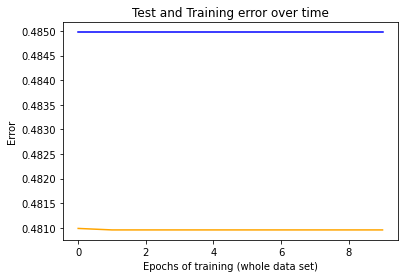

In [251]:
# plot the current training session
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses, color='orange')
plt.plot(range(len(test_loss)), test_loss, color='blue')
plt.xlabel('Epochs of training (whole data set)')
plt.ylabel('Error')
plt.title('Test and Training error over time')
plt.savefig('model2perf.jpg')
plt.show()




# Current Status

## Logistic Regression
I feel as though the Logistic Regression Model is likely being held back by 
1. Weaknesses in the data set
2. Uncertainty

The best bang for my buck improvements are likely

1. Implementing abstension
2. Build a new data set (time and money sink)
3. Try out SVM

## ANN
The artificial neural network model might just be too deep or complicated. The current state of it is leading to overfitting. I'm getting training errors of like 38% and test errors of like 48% which is no bueno.

1. Simplify model
2. Implement Abstension
3. Build new data set

# Next steps
I need some deliverables so I plan on making sure I have well documented evidence of my current results before moving on. I think I'll do things in this order.

1. Build training error vs. testing error graph for both existing models.
2. Add abstension to both models, make new graphs.
3. Simplyify ANN
4. Look into building new data set
5. Make SVM

# SVM

I am going to make a Simple Vector machine and maybe add in the kernel trick too. We'll see ig. I haven't completely decided yet.